In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Air_Traffic_Passenger_Statistics_20250111.csv")
df.head()

,Activity Period,Activity Period Start Date,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count,data_as_of,data_loaded_at
0,199907,1999/07/01,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,31432,2024/12/20 02:02:16 PM,2024/12/22 03:02:48 PM
1,199907,1999/07/01,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,31353,2024/12/20 02:02:16 PM,2024/12/22 03:02:48 PM
2,199907,1999/07/01,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,2518,2024/12/20 02:02:16 PM,2024/12/22 03:02:48 PM
3,199907,1999/07/01,Aeroflot Russian International Airlines,NaN,Aeroflot Russian International Airlines,NaN,International,Europe,Deplaned,Other,Terminal 2,D,1324,2024/12/20 02:02:16 PM,2024/12/22 03:02:48 PM
4,199907,1999/07/01,Aeroflot Russian International Airlines,NaN,Aeroflot Russian International Airlines,NaN,International,Europe,Enplaned,Other,Terminal 2,D,1198,2024/12/20 02:02:16 PM,2024/12/22 03:02:48 PM


In [2]:
df = df.fillna("").drop(labels=['Activity Period', 'data_as_of', 'data_loaded_at'], axis=1)

In [3]:
df['Activity Period Start Date'] #Data ranges July 1999 to October 2024 (Incomplete data in 1999 and 2024)

0        1999/07/01
1        1999/07/01
2        1999/07/01
3        1999/07/01
4        1999/07/01
            ...    
37007    2024/10/01
37008    2024/10/01
37009    2024/10/01
37010    2024/10/01
37011    2024/10/01
Name: Activity Period Start Date, Length: 37012, dtype: object

In [4]:
df["Activity Period Start Date"] = pd.to_datetime(df['Activity Period Start Date'])
yearly_trends = df.groupby(df["Activity Period Start Date"].dt.to_period('Y'))['Passenger Count'].sum()
yearly_trends = yearly_trends[yearly_trends.index >= '2000'] # Omitting data from July 1999 - December 1999 due to irregular timeframe

In [5]:
monthly_trends = df.groupby(df["Activity Period Start Date"].dt.to_period('M'))['Passenger Count'].sum()
monthly_trends = monthly_trends[monthly_trends.index >= '2000-01'] # Omitting data from July 1999 - December 1999 due to irregular timeframe

In [6]:
# Based on activity period start dates, 2024 is missing 2 months of data (November and December 2024)
# Simple average-based estimation used for calculating estimated 2024 numbers
monthly_counts_2024 = monthly_trends.loc['2024-01':'2024-10'].tolist()
monthly_counts_2024

std_dev_2024 = np.std(monthly_counts_2024, ddof=1)
months_of_data_2024 = len(monthly_counts_2024)

SE_monthly_avg = std_dev_2024 / np.sqrt(months_of_data_2024)


monthly_average_2024 = yearly_trends['2024'] / months_of_data_2024
estimated_missing = monthly_average_2024 * (12 - months_of_data_2024)
adjusted_2024 = yearly_trends['2024'] + estimated_missing
yearly_trends['2024'] = adjusted_2024



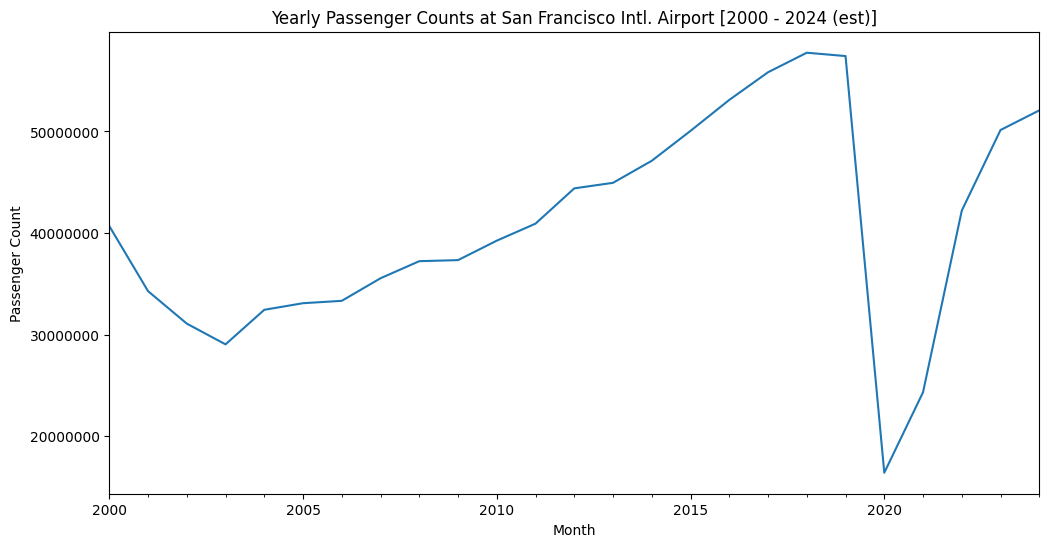

In [7]:
plt.figure(figsize=(12, 6))
ax = plt.gca()
yearly_trends.plot(kind='line', title="Yearly Passenger Counts at San Francisco Intl. Airport [2000 - 2024 (est)]", xlabel= "Month", ylabel= "Passenger Count", ax = ax)
ax.ticklabel_format(style='plain', axis='y')

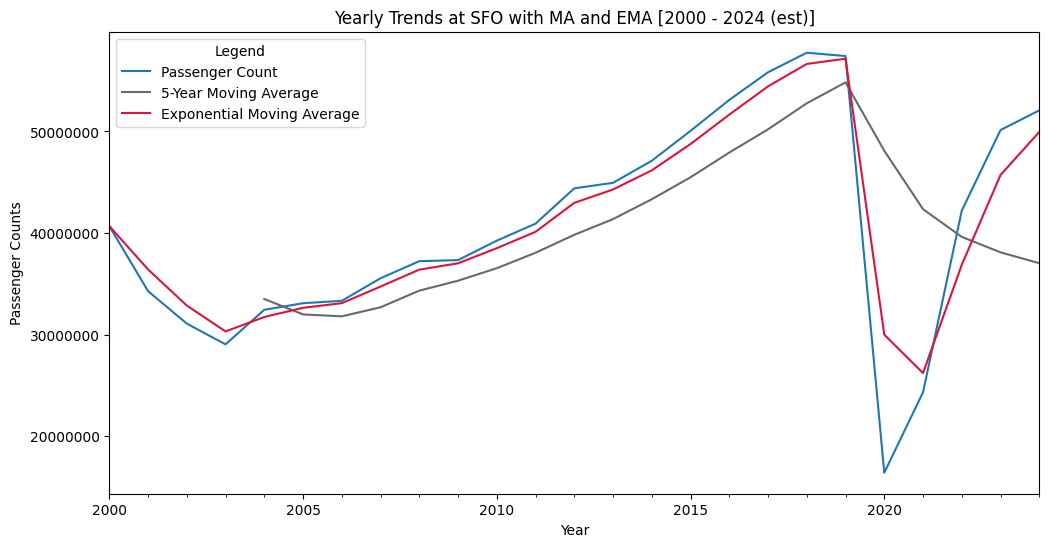

In [8]:
yearly_trends_ma = yearly_trends.rolling(window=5).mean().dropna()
yearly_trends_ema = yearly_trends.ewm(span=2, adjust=False).mean()
plt.figure(figsize=(12, 6))
ax = plt.gca()
yearly_trends.plot(kind='line', title='Yearly Trends at SFO with MA and EMA [2000 - 2024 (est)]', label='Passenger Count', ax = ax).ticklabel_format(style='plain', axis='y')
yearly_trends_ma.plot(kind='line', color='dimgrey', label='5-Year Moving Average')
yearly_trends_ema.plot(kind='line', color='crimson', label='Exponential Moving Average')
plt.legend(title="Legend", loc='upper left')
plt.xlabel('Year')
plt.ylabel('Passenger Counts')
plt.show()

In [9]:
print(yearly_trends['2024']) #Estimated Passenger Count for 2024

52072248


In [10]:
latest_ema = yearly_trends_ema.iloc[-1]
slope = latest_ema - yearly_trends_ema.iloc[-2]
future_year = [2025]
predictions = [latest_ema + (i + 1) * slope for i in range(len(future_year))]
future_predictions_table = pd.DataFrame({'Year': future_year, 'Predicted Counts': predictions})
pd.set_option('display.float_format', '{:.0f}'.format)
future_predictions_table #extrapolated results with EMA span / window set to 2

,Year,Predicted Counts
0,2025,54189284


In [11]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(yearly_trends) #on alpha = 0.05
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -2.7429775663908122
p-value: 0.0668919282377414
Critical Values: {'1%': np.float64(-3.7529275211638033), '5%': np.float64(-2.998499866852963), '10%': np.float64(-2.6389669754253307)}


<Figure size 1200x600 with 0 Axes>

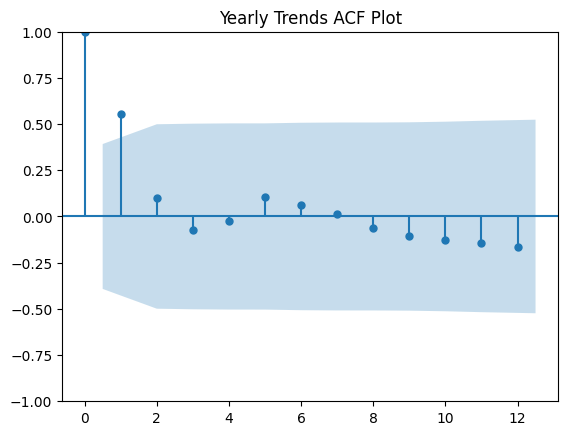

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(yearly_trends, lags=12, title='Yearly Trends ACF Plot')
plt.show()

<Figure size 1200x600 with 0 Axes>

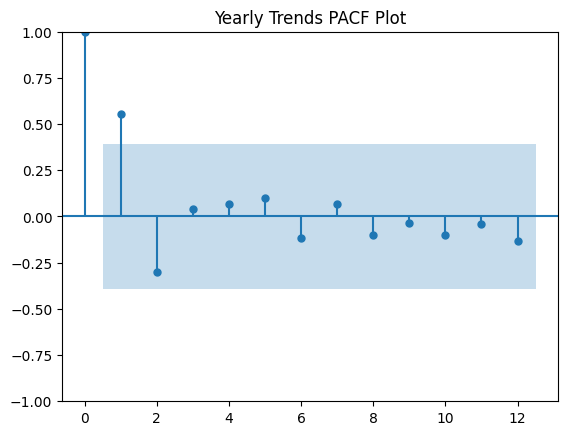

In [13]:
plt.figure(figsize=(12, 6))
plot_pacf(yearly_trends, lags=12, title='Yearly Trends PACF Plot')
plt.show()

***

Operating Airline
United Airlines       414771382
American Airlines      77157687
SkyWest Airlines       76296515
Delta Air Lines        65054159
Southwest Airlines     47516575
Alaska Airlines        46757117
Virgin America         37843920
US Airways             26831451
JetBlue Airways        18963104
Air Canada             15901475
Name: Passenger Count, dtype: int64


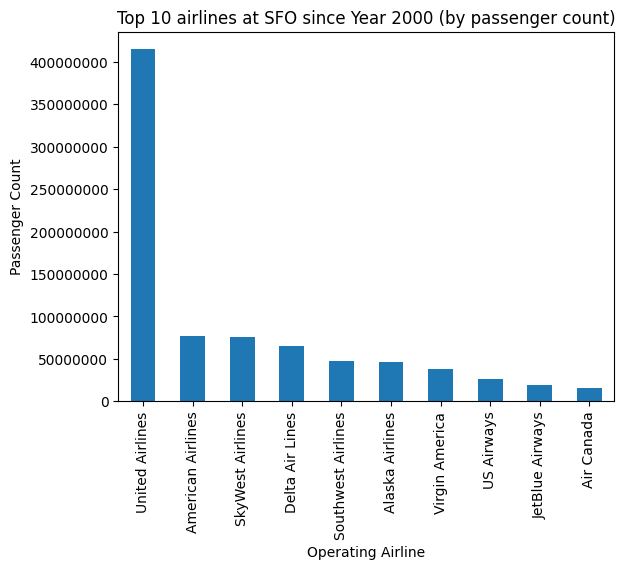

In [14]:
airlines_to_merge = ['United Airlines', 'United Airlines - Pre 07/01/2013']
merged_airline_name = 'United Airlines'
df["Operating Airline"] = df["Operating Airline"].replace(airlines_to_merge, merged_airline_name)
# Combined United Airlines flights


filter_df = df[df['Activity Period Start Date'].dt.to_period('Y') >= '2000'] #only using flights since Year 2000, six-months period of 1999 omitted

airline_passengercounts = filter_df.groupby(df["Operating Airline"])["Passenger Count"].sum()
print(airline_passengercounts.sort_values(ascending=False).head(10))
airline_passengercounts.sort_values(ascending=False).head(10).plot(kind='bar', title='Top 10 airlines at SFO since Year 2000 (by passenger count)', ylabel='Passenger Count').ticklabel_format(style='plain', axis='y')

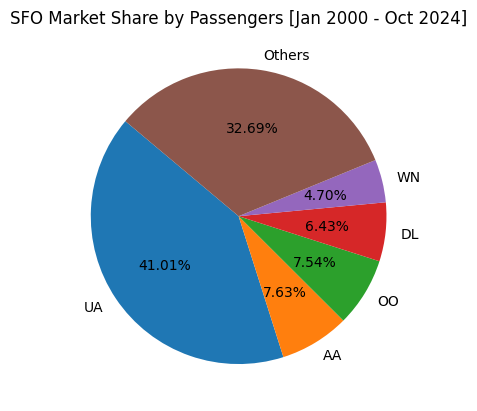

In [15]:
filtered_operating = filter_df.groupby(['Operating Airline IATA Code'])["Passenger Count"].sum().sort_values(ascending=False)
top_airlines = filtered_operating[:5]
others = filtered_operating[5:].sum()
top_airlines["Others"] = others

plt.pie(top_airlines, labels=top_airlines.index, autopct='%1.2f%%', startangle=140)
plt.title('SFO Market Share by Passengers [Jan 2000 - Oct 2024]')
plt.show()

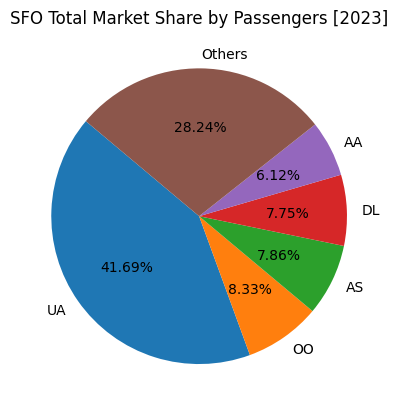

In [16]:
filter_2023 = df[df['Activity Period Start Date'].dt.to_period('Y') == '2023']
filtered_operating_2023 = filter_2023.groupby(['Operating Airline IATA Code'])["Passenger Count"].sum().sort_values(ascending=False)
top_airlines_2023 = filtered_operating_2023[:5]
others_2023 = filtered_operating_2023[5:].sum()
top_airlines_2023["Others"] = others_2023

plt.pie(top_airlines_2023, labels=top_airlines_2023.index, autopct='%1.2f%%', startangle=140)
plt.title('SFO Total Market Share by Passengers [2023]')
plt.show()

Operating Airline IATA Code
UA    5139127
AC     922179
BR     594269
BA     427926
LH     388753
AI     387752
TK     338569
AS     327648
AM     288747
VS     280556
Name: Passenger Count, dtype: int64


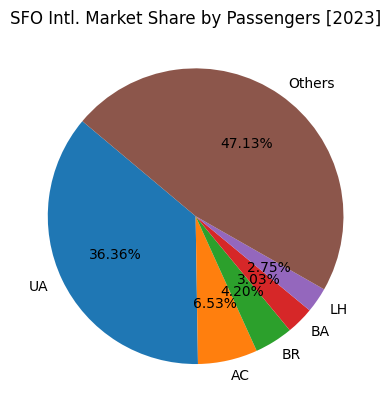

In [17]:
filter_2023_international = df[(df['Activity Period Start Date'].dt.to_period('Y') == '2023') & (df['GEO Summary'] == 'International')]
filtered_operating_2023_international = filter_2023_international.groupby(['Operating Airline IATA Code'])["Passenger Count"].sum().sort_values(ascending=False)
top_intl_airlines_2023 = filtered_operating_2023_international[:5]
others_intl_2023 = filtered_operating_2023_international[5:].sum()
top_intl_airlines_2023["Others"] = others_intl_2023

print(filtered_operating_2023_international.sort_values(ascending=False).head(10))
plt.pie(top_intl_airlines_2023, labels=top_intl_airlines_2023.index, autopct='%1.2f%%', startangle=140)
plt.title('SFO Intl. Market Share by Passengers [2023]')
plt.show()

Operating Airline IATA Code
UA    15766471
OO     4138188
DL     3888064
AS     3614245
AA     3070705
WN     2121533
B6     1369534
F9     1137921
QX      343822
HA      275412
Name: Passenger Count, dtype: int64


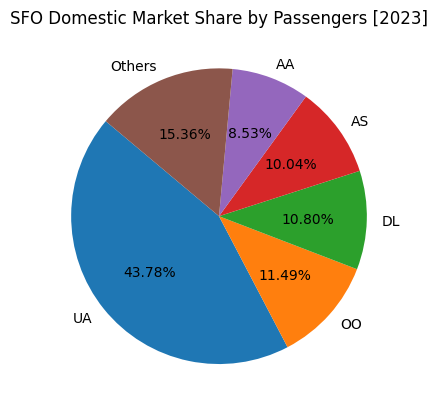

In [18]:
filter_2023_domestic = df[(df['Activity Period Start Date'].dt.to_period('Y') == '2023') & (df['GEO Summary'] == 'Domestic')]
filtered_operating_2023_domestic = filter_2023_domestic.groupby(['Operating Airline IATA Code'])["Passenger Count"].sum().sort_values(ascending=False)
top_domestic_airlines_2023 = filtered_operating_2023_domestic[:5]
others_domestic_2023 = filtered_operating_2023_domestic[5:].sum()
top_domestic_airlines_2023["Others"] = others_domestic_2023

print(filtered_operating_2023_domestic.sort_values(ascending=False).head(10))
plt.pie(top_domestic_airlines_2023, labels=top_domestic_airlines_2023.index, autopct='%1.2f%%', startangle=140)
plt.title('SFO Domestic Market Share by Passengers [2023]')
plt.show()